In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
main_dir = '/content/gdrive/My Drive/UpworkNotebooks/Opera Files/'

!ls -ltra '{main_dir}'/.

Mounted at /content/gdrive
ls: '/content/gdrive/My Drive/UpworkNotebooks/Opera Files//./Audios': No such file or directory
total 32
lrw------- 1 root root    0 May  1 02:47 Audios -> /content/gdrive/.shortcut-targets-by-id/1DOvML8hO7v6XEq5-HQAQSvo7eKca7tSf/Audios
drwx------ 2 root root 4096 Sep 12 11:40 New_male_only_200_each
drwx------ 2 root root 4096 Sep 22 14:29 All_Data
drwx------ 2 root root 4096 Sep 22 14:40 Keras_Tuner_Logs
drwx------ 2 root root 4096 Sep 22 14:57 Documentation
drwx------ 2 root root 4096 Sep 22 15:02 Helper_Notebooks
drwx------ 2 root root 4096 Sep 22 15:03 Csv_Files
drwx------ 2 root root 4096 Sep 22 15:05 Main_Notebooks
drwx------ 2 root root 4096 Oct 27 13:51 CNN_Data


In [2]:
!pip install -q librosa
!pip install -q tensorflow_io
!pip install -q pysoundfile
!pip install -q -U keras-tuner

In [3]:
import os
import librosa

from IPython import display
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_io as tfio

import keras_tuner as kt
from ast import literal_eval

import time
%matplotlib inline

import urllib.request as urllib2 # For python3
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, normalize
from sklearn.model_selection import train_test_split

from matplotlib.colors import LogNorm
from PIL import Image

from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.applications import vgg16, vgg19
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [4]:
#creating data directories.
#if already present, ignore

base_dir = main_dir +  'CNN_Data/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

paths = [base_dir, train_dir, validation_dir, test_dir]

for path in paths:
  if os.path.exists(path)==False:
    print('Creating this directory: ', path)
    !mkdir "{path}"
  print('Directory already exists!')



#!mkdir '{base_dir}' "{train_dir}" '{validation_dir}' '{test_dir}'

Directory already exists!
Directory already exists!
Directory already exists!
Directory already exists!


In [5]:
data = pd.read_csv(main_dir + "Csv_Files/males_500_cleaner_for_CNN.csv")
data = data.sample(frac=1)
data.head()

,path,subregister,Target
3196,/content/gdrive/My Drive/UpworkNotebooks/Opera...,tenor_lyric,7
2060,/content/gdrive/My Drive/UpworkNotebooks/Opera...,tenor_leggero,5
3486,/content/gdrive/My Drive/UpworkNotebooks/Opera...,tenor_dramatic,8
584,/content/gdrive/My Drive/UpworkNotebooks/Opera...,baritone_dramatic,1
34,/content/gdrive/My Drive/UpworkNotebooks/Opera...,baritone_bassbaritones,0


In [6]:
len(data)

3889

In [7]:
#split the data into train, test and validation
def data_splits(data, test_split, val_split):
  '''creating the train, validation and test sets'''
  assert test_split < 0.5
  assert val_split < 0.5
  len_data = len(data)
  test_inv  = int(round(1/test_split))
  val_inv = int(round(1/val_split))
  
  x_data = data[len_data//test_inv:]
  test_data = data[0:len_data//test_inv]
  val_data = x_data[0:len(x_data)//val_inv]
  train_data = x_data[len(x_data)//val_inv:]

  print('Total data samples: ', len_data)
  print('Train samples: ', len(train_data))
  print('Validation samples: ', len(val_data))
  print('Test samples: ', len(test_data))

  return [train_data, test_data, val_data]

In [8]:
dataset = data_splits(data[0:800], 0.1, 0.2)

Total data samples:  800
Train samples:  576
Validation samples:  144
Test samples:  80


In [17]:
dataset[1].head()

,path,subregister,Target
993,/content/gdrive/My Drive/UpworkNotebooks/Opera...,baritone_lyric,2
2431,/content/gdrive/My Drive/UpworkNotebooks/Opera...,tenor_leggero,5
1348,/content/gdrive/My Drive/UpworkNotebooks/Opera...,bass_cantante,3
3655,/content/gdrive/My Drive/UpworkNotebooks/Opera...,tenor_dramatic,8
1536,/content/gdrive/My Drive/UpworkNotebooks/Opera...,bass_cantante,3


# Helper Functions


In [9]:
def padding(array, des_height, des_width):
  """
  :param array: numpy array
  :param des_height: desired height
  :param des_width: desired width
  :return: padded array
  """
  height = array.shape[0]
  width = array.shape[1]
  a = max((des_height - height) // 2, 0)
  aa = max(des_height - a - height, 0)
  b = max((des_width - width) // 2, 0)
  bb = max(des_width - b - width,0)

  return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

In [10]:
def generate_features(y_cut):

  #max audio file feature width
  max_size=330
  sr = 28000
  
  #create features: stft, MFCCs, spec_centroid, spec_bw, chroma_stft
  stft = padding(np.abs(librosa.stft(y_cut, n_fft=255, hop_length = 512)), 128, max_size)
  MFCCs = padding(librosa.feature.mfcc(y_cut,n_mfcc=128),128,max_size)
  spec_centroid = librosa.feature.spectral_centroid(y=y_cut, sr=sr)
  chroma_stft = librosa.feature.chroma_stft(y=y_cut, sr=sr)
  spec_bw = librosa.feature.spectral_bandwidth(y=y_cut, sr=sr)
  
  #pad and append the spec_centroid, spec_bw

  image = np.array([padding(normalize(spec_bw),1, max_size)]).reshape(1,max_size)
  image = np.append(image,padding(normalize(spec_centroid),1, max_size), axis=0) 
  
  #repeat the padded spec_bw, spec_centroid and chroma stft until they are stft and MFCC-sized
  for i in range(0,9):
      image = np.append(image,padding(normalize(spec_bw),1, max_size), axis=0)
      image = np.append(image, padding(normalize(spec_centroid),1, max_size), axis=0)
      image = np.append(image, padding(normalize(chroma_stft),12, max_size), axis=0)
  image=np.dstack((image,np.abs(stft)))
  image=np.dstack((image,MFCCs))

  return image

In [102]:
ex_path = data['path'][0]

In [109]:
image = generate_features(librosa.load(ex_path,sr=28000)[0])

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


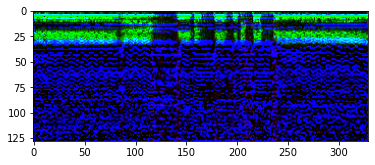

In [116]:
plt.figure()
plt.imshow(image)
# plt.savefig(base_dir + 'lol6.png')
# cv2.imwrite(base_dir + 'new1.png', image)

In [111]:
image.shape

(128, 329, 3)

In [143]:
# array = (image*255).astype(np.uint8)
data2 = Image.fromarray((image*255).astype(np.uint8))
data2 = data2.convert('RGB')
data2.save(base_dir + 'lol21.png')

In [11]:
def get_features(data):
  features = [generate_features(librosa.load(filename,sr=28000)[0])[np.newaxis, ...] for filename in data] 
  print('done')
  output=np.concatenate(features,axis=0)     
  return(np.array(output))

In [15]:

def mfccs_to_dir_modified(dataset, base_dir):
  train, test, validation = dataset
  dataset = [train, test, validation]
  dataset_names = ['train', 'test', 'validation']

  for subregister in train['subregister'].unique():
    for sub_directory in os.listdir(base_dir):
      new_dir = base_dir + '{}/'.format(sub_directory) + '{}'.format(subregister)
      print(os.path.basename(new_dir))
      !mkdir '{new_dir}'

  
  for i in range(len(dataset_names)):
    for file_name in dataset[i]['path']:
      sub_directory = os.path.basename(os.path.dirname(file_name))
      # print(sub_directory)
      new_dir = base_dir + '{}/'.format(dataset_names[i]) + '{}'.format(sub_directory)
      # print(new_dir)
      # audio, sample_rate = librosa.load(file_name) 
      # mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=128)
      image_features = generate_features(librosa.load(file_name,sr=28000)[0])
      # print(image_features)

      # try:
      #   array = np.reshape(image_features, (128, 520))
      # except ValueError:
      #   pass
      # data = Image.fromarray(image_features)
      # data = data.convert('RGB')
      # data.save(new_dir + '/{}.png'.format(os.path.basename(file_name)))
      # cv2.imwrite(new_dir + '/{}.png'.format(os.path.basename(file_name)), image_features)

      # im_rgb = cv2.cvtColor(im_cv, cv2.COLOR_BGR2RGB)
      data = Image.fromarray((image_features*255).astype(np.uint8))
      data = data.convert('RGB')
      data.save(new_dir + '/{}.png'.format(os.path.basename(file_name)))

  pass


In [16]:
dataset = data_splits(data[0:900], 0.1, 0.2)
mfccs_to_dir_modified(dataset, base_dir)

Total data samples:  900
Train samples:  648
Validation samples:  162
Test samples:  90
baritone_bassbaritones
mkdir: cannot create directory ‘/content/gdrive/My Drive/UpworkNotebooks/Opera Files/CNN_Data/train/baritone_bassbaritones’: File exists
baritone_bassbaritones
mkdir: cannot create directory ‘/content/gdrive/My Drive/UpworkNotebooks/Opera Files/CNN_Data/validation/baritone_bassbaritones’: File exists
baritone_bassbaritones
mkdir: cannot create directory ‘/content/gdrive/My Drive/UpworkNotebooks/Opera Files/CNN_Data/test/baritone_bassbaritones’: File exists
tenor_dramatic
mkdir: cannot create directory ‘/content/gdrive/My Drive/UpworkNotebooks/Opera Files/CNN_Data/train/tenor_dramatic’: File exists
tenor_dramatic
mkdir: cannot create directory ‘/content/gdrive/My Drive/UpworkNotebooks/Opera Files/CNN_Data/validation/tenor_dramatic’: File exists
tenor_dramatic
mkdir: cannot create directory ‘/content/gdrive/My Drive/UpworkNotebooks/Opera Files/CNN_Data/test/tenor_dramatic’: File

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/cor

In [31]:
conv_base = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(128, 329, 3) )
# conv_base2 = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=)

In [32]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 329, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 329, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 329, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 164, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 164, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 164, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 82, 128)       0     

In [33]:
#freezing the convolutional base
conv_base.trainable=False


# Data Augmentation

In [35]:
from keras import models
from keras import layers
from keras import optimizers
from tensorflow.keras.optimizers import  RMSprop

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(128,329), batch_size=20,
                                                    class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(128,329), batch_size=20,
                                                        class_mode='categorical')



Found 648 images belonging to 9 classes.
Found 162 images belonging to 9 classes.


In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=0.001), metrics=['acc'])
history = model.fit(train_generator, steps_per_epoch=10, epochs=80,validation_data=validation_generator)

Epoch 1/80
10/10 [==============================] - 153s 16s/step - loss: 3.9919 - acc: 0.0950 - val_loss: 2.4237 - val_acc: 0.1173
Epoch 2/80
10/10 [==============================] - 151s 16s/step - loss: 2.3554 - acc: 0.1050 - val_loss: 2.3114 - val_acc: 0.1296
Epoch 3/80
10/10 [==============================] - 151s 16s/step - loss: 2.3158 - acc: 0.1100 - val_loss: 2.2325 - val_acc: 0.1296
Epoch 4/80
10/10 [==============================] - 152s 16s/step - loss: 2.2348 - acc: 0.1650 - val_loss: 2.2069 - val_acc: 0.1481
Epoch 5/80
10/10 [==============================] - 151s 16s/step - loss: 2.3931 - acc: 0.1000 - val_loss: 2.1944 - val_acc: 0.1605
Epoch 6/80
10/10 [==============================] - 151s 16s/step - loss: 2.1840 - acc: 0.1550 - val_loss: 2.1813 - val_acc: 0.1358
Epoch 7/80
10/10 [==============================] - 151s 16s/step - loss: 2.2372 - acc: 0.1500 - val_loss: 2.2764 - val_acc: 0.0741
Epoch 8/80
10/10 [==============================] - 151s 16s/step - loss: 2.

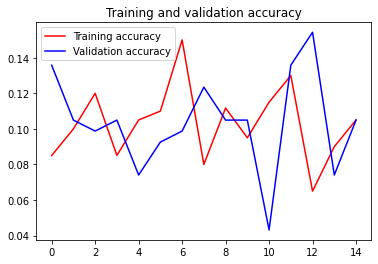

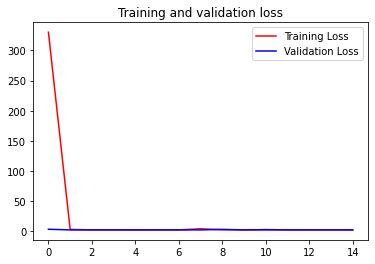

In [22]:
def model_performance(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()
  pass

model_performance(history)